Processing dataset for 7-day prediction
Features being dropped: []
Loading data...
Test set contains 7 unique dates.
Creating spatial features...


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Processing chunks: 100%|██████████| 1641/1641 [11:17<00:00,  2.42it/s]


Creating spatial features...


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Processing chunks: 100%|██████████| 56/56 [00:12<00:00,  4.40it/s]


Using device: cuda


Processing days:   0%|          | 0/7 [00:00<?, ?it/s]

Day: 2024-02-09, Epoch: 1/3, Loss: 0.008021
Day: 2024-02-09, Epoch: 2/3, Loss: 0.004768
Day: 2024-02-09, Epoch: 3/3, Loss: 0.004281


Processing days:  14%|█▍        | 1/7 [04:24<26:24, 264.13s/it]

Day: 2024-02-10, Epoch: 1/3, Loss: 0.004776
Day: 2024-02-10, Epoch: 2/3, Loss: 0.004734
Day: 2024-02-10, Epoch: 3/3, Loss: 0.004412


Processing days:  29%|██▊       | 2/7 [09:27<23:55, 287.11s/it]

Day: 2024-02-11, Epoch: 1/3, Loss: 0.005019
Day: 2024-02-11, Epoch: 2/3, Loss: 0.004989
Day: 2024-02-11, Epoch: 3/3, Loss: 0.004840


Processing days:  43%|████▎     | 3/7 [13:53<18:29, 277.43s/it]

Day: 2024-02-12, Epoch: 1/3, Loss: 0.005215
Day: 2024-02-12, Epoch: 2/3, Loss: 0.005161
Day: 2024-02-12, Epoch: 3/3, Loss: 0.004929


Processing days:  57%|█████▋    | 4/7 [19:08<14:37, 292.51s/it]

Day: 2024-02-13, Epoch: 1/3, Loss: 0.005305
Day: 2024-02-13, Epoch: 2/3, Loss: 0.004973
Day: 2024-02-13, Epoch: 3/3, Loss: 0.003969


Processing days:  71%|███████▏  | 5/7 [24:44<10:16, 308.10s/it]

Day: 2024-02-14, Epoch: 1/3, Loss: 0.003838
Day: 2024-02-14, Epoch: 2/3, Loss: 0.003617
Day: 2024-02-14, Epoch: 3/3, Loss: 0.003212


Processing days:  86%|████████▌ | 6/7 [29:18<04:56, 296.61s/it]

Day: 2024-02-15, Epoch: 1/3, Loss: 0.003182
Day: 2024-02-15, Epoch: 2/3, Loss: 0.003301
Day: 2024-02-15, Epoch: 3/3, Loss: 0.003235


Processing days: 100%|██████████| 7/7 [33:40<00:00, 288.65s/it]


Results saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\NN\strap_results.csv with location data
Daily metrics saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\NN\strap_results_daily_metrics.csv

===== ST-RAP MODEL EVALUATION =====

=== Overall Metrics ===
RMSE: 0.2719
MAE: 0.1085
R²: 0.9108
MAPE: 67.1417%

=== Daily Performance ===
      date     rmse      mae       mape  n_samples
2024-02-09 0.347614 0.150193 108.068932       7864
2024-02-10 0.404449 0.179513  93.489441       7864
2024-02-11 0.317391 0.126039  82.560407       7864
2024-02-12 0.270097 0.108942  73.180087       7864
2024-02-13 0.189045 0.085480  54.308016       7864
2024-02-14 0.109502 0.061557  32.858870       7864
2024-02-15 0.108421 0.047467  25.525898       7864

=== Performance Statistics ===
MAE:
  Average: 0.1085
  Min: 0.0475 (Day: 2024-02-15 00:00:00)
  Max: 0.1795 (Day: 2024-02-10 00:00:00)

RMSE:
  Average: 0.2495
  Min: 0.1084 (Day: 2024-02-15 00:00:00)
  Max: 0.4044 (Day: 2024-02-10 00:00

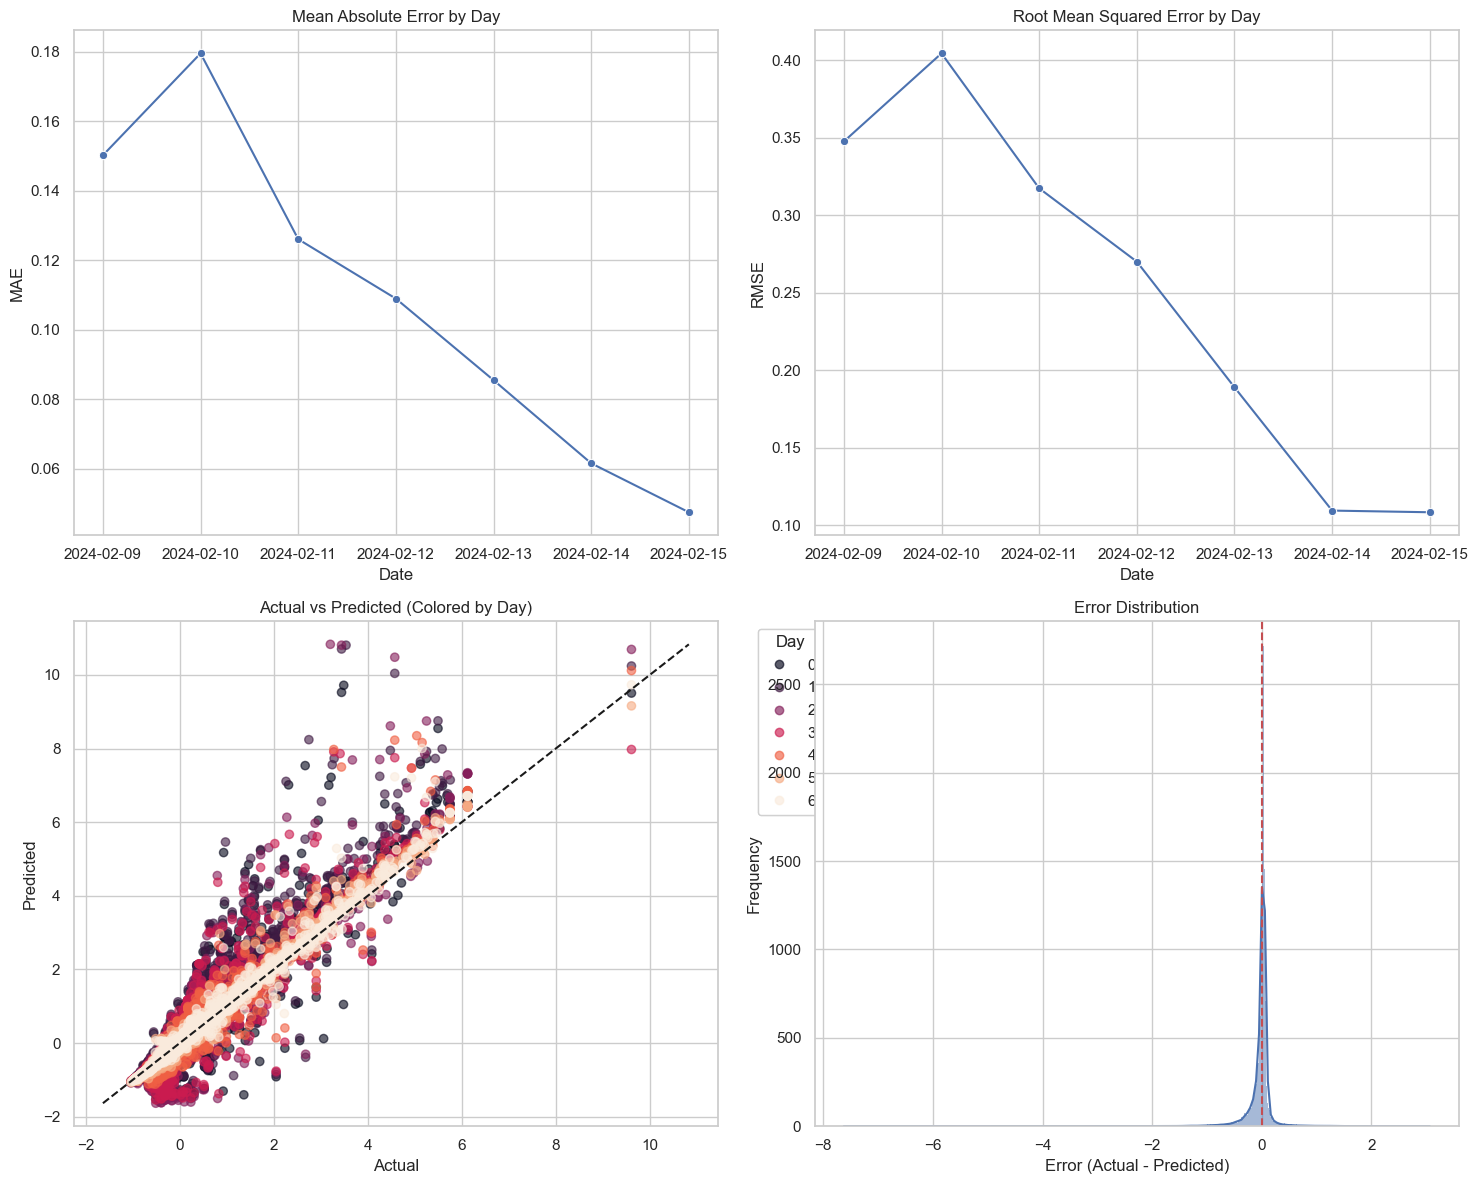

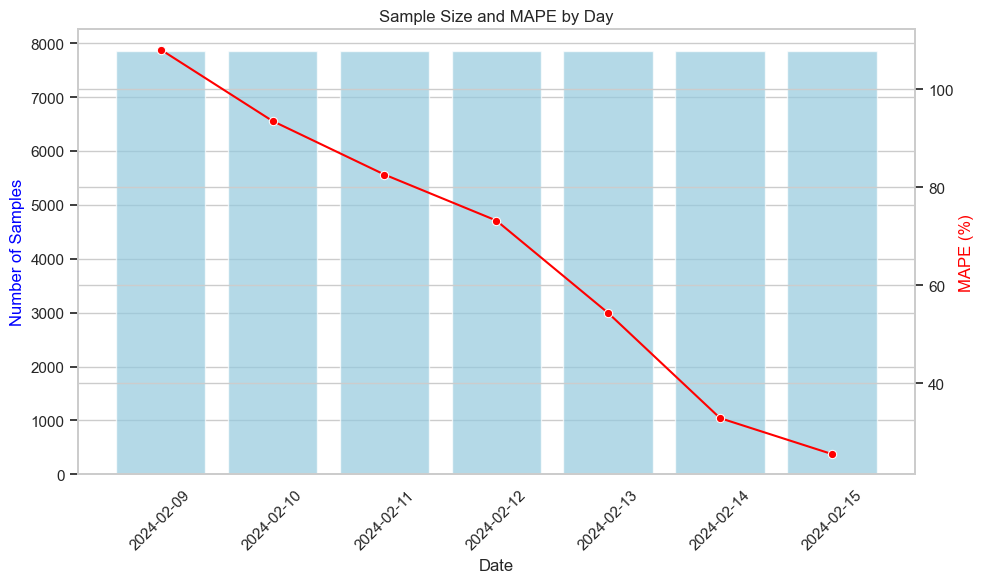

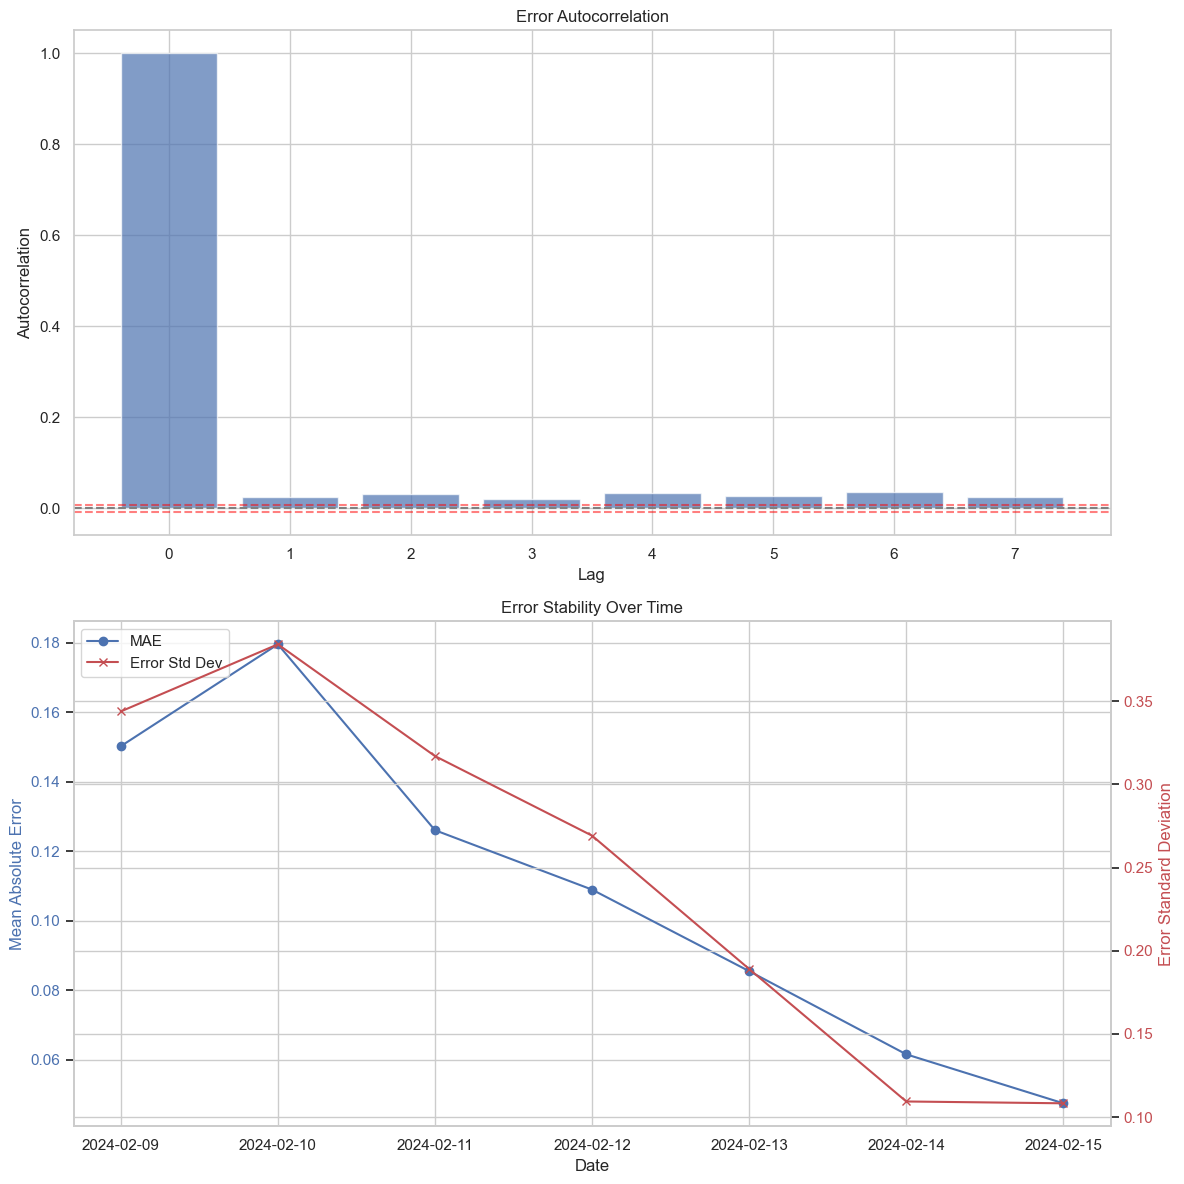

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.nn import SAGEConv
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
from tqdm import tqdm
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import BallTree
from math import radians
from statsmodels.tsa.stattools import acf
import numpy as np
import matplotlib.pyplot as plt


class Time2VecEncoding(nn.Module):
    """Time2Vec encoding for temporal features"""
    def __init__(self, h_dim, scale=1):
        super(Time2VecEncoding, self).__init__()
        self.w0 = nn.parameter.Parameter(torch.randn(1, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(1, h_dim-1))
        self.b = nn.parameter.Parameter(torch.randn(h_dim-1))
        self.f = torch.sin
        self.scale = scale

    def forward(self, time):
        # Ensure time is 2D: [batch_size, 1]
        if len(time.shape) == 1:
            time = time.unsqueeze(-1)
        elif len(time.shape) == 3:
            # If time has shape [batch_size, seq_len, 1], take the last time step
            time = time[:, -1, :].unsqueeze(-1)
            
        # Scale time
        time = time / self.scale
        
        # Calculate linear and periodic components
        v1 = torch.matmul(time, self.w0) + self.b0  # Shape: [batch_size, 1]
        v2 = self.f(torch.matmul(time, self.w) + self.b)  # Shape: [batch_size, h_dim-1]
        
        return torch.cat([v1, v2], dim=1)  # Shape: [batch_size, h_dim]

class STRAP(nn.Module):
    """Streamlined implementation of ST-RAP model"""
    def __init__(self, input_dim, temporal_dim, hidden_dim=128, num_gru_layers=2):
        super(STRAP, self).__init__()
        
        # Feature embeddings
        self.property_embedding = nn.Linear(input_dim, hidden_dim)
        self.time_embedding = Time2VecEncoding(hidden_dim, scale=1000)
        
        # Temporal GRU layers
        self.gru = nn.GRU(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_gru_layers,
            batch_first=True
        )
        self.temporal_norm = nn.LayerNorm(hidden_dim)
        
        # Spatial graph layers
        self.graph_conv = SAGEConv(hidden_dim, hidden_dim)
        self.spatial_norm = nn.LayerNorm(hidden_dim)
        
        # Final prediction layers
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x, edge_index=None, time_features=None):
        batch_size = x.size(0)
        
        # Property embeddings
        property_emb = self.property_embedding(x)
        
        # Process time features if provided
        if time_features is not None:
            # Take the first feature as the temporal value
            # In practice, you might want to use a more sophisticated approach
            time_val = time_features[:, 0]  # Shape: [batch_size]
            time_emb = self.time_embedding(time_val)  # Shape: [batch_size, hidden_dim]
            property_emb = property_emb + time_emb
        
        # Reshape for GRU (adding sequence dimension)
        temporal_input = property_emb.unsqueeze(1)  # Shape: [batch_size, 1, hidden_dim]
            
        # Process with GRU
        temporal_output, _ = self.gru(temporal_input)  # Shape: [batch_size, 1, hidden_dim]
        temporal_output = self.temporal_norm(temporal_output[:, -1])  # Shape: [batch_size, hidden_dim]
        
        # Process with graph convolution if edge_index provided
        if edge_index is not None and edge_index.numel() > 0:
            spatial_output = self.graph_conv(temporal_output, edge_index)
            spatial_output = self.spatial_norm(spatial_output)
        else:
            spatial_output = torch.zeros_like(temporal_output)
        
        # Combine temporal and spatial outputs
        combined = torch.cat([temporal_output, spatial_output], dim=1)
        
        # Final prediction
        output = self.predictor(combined).squeeze(-1)
        
        return output

def create_edge_index_efficient(data, k_neighbors=5, distance_threshold=2.0, chunk_size=1000):
    """
    Create spatial edge index efficiently using BallTree and chunking
    """
    print("Creating spatial edge index efficiently...")
    coords = data[['latitude', 'longitude']].values
    n_samples = len(coords)
    
    # Convert to radians for BallTree
    coords_rad = np.radians(coords)
    
    # Create BallTree
    tree = BallTree(coords_rad, metric='haversine')
    
    # Create edge index
    edge_index = []
    
    # Process in chunks to avoid memory issues
    for i in tqdm(range(0, n_samples, chunk_size)):
        end_idx = min(i + chunk_size, n_samples)
        chunk_coords = coords_rad[i:end_idx]
        
        # Query k+1 nearest neighbors (including self)
        distances, indices = tree.query(chunk_coords, k=k_neighbors+1)
        
        # Convert distances from radians to km
        distances = distances * 6371.0  # Earth radius in km
        
        # Add edges for each point in chunk
        for j in range(len(chunk_coords)):
            point_idx = i + j
            for k in range(1, k_neighbors+1):  # Skip self (index 0)
                neighbor_idx = indices[j, k]
                distance = distances[j, k]
                
                if distance <= distance_threshold:
                    edge_index.append([point_idx, neighbor_idx])
                    # Add reverse edge for undirected graph
                    edge_index.append([neighbor_idx, point_idx])
    
    # Remove duplicates
    edge_index = list(set(tuple(edge) for edge in edge_index))
    edge_index = [list(edge) for edge in edge_index]
    
    return torch.tensor(edge_index, dtype=torch.long).t()

def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using the Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def create_spatial_features(df, k_neighbors=5, chunk_size=1000, n_jobs=-1):
    """Create spatial features similar to XGBoost implementation"""
    print("Creating spatial features...")
    city_center_lat, city_center_lon = 48.8566, 2.3522  # Paris coordinates
    
    # Calculate distance to city center and north-south position
    df['distance_to_center'] = df.apply(
        lambda row: calculate_distance(
            row['latitude'], 
            row['longitude'], 
            city_center_lat, 
            city_center_lon
        ),
        axis=1
    )
    
    df['north_south'] = df['latitude'] - city_center_lat
    
    # Create BallTree for nearest neighbor calculations
    coords = np.radians(df[['latitude', 'longitude']].values)
    tree = BallTree(coords, metric='haversine')
    
    # Process in chunks
    n_chunks = math.ceil(len(df) / chunk_size)
    chunks = np.array_split(df, n_chunks)
    
    # KNN features
    knn_price_mean = np.zeros(len(df))
    knn_price_std = np.zeros(len(df))
    knn_price_median = np.zeros(len(df))
    price_diff = np.zeros(len(df))
    
    start_idx = 0
    for chunk in tqdm(chunks, desc="Processing chunks"):
        chunk_size = len(chunk)
        chunk_coords = np.radians(chunk[['latitude', 'longitude']].values)
        
        # Find k+1 nearest neighbors (including self)
        distances, indices = tree.query(chunk_coords, k=k_neighbors+1)
        
        # Calculate neighbor statistics
        for i in range(chunk_size):
            # Skip self (index 0)
            neighbor_indices = indices[i, 1:]
            prices = df.iloc[neighbor_indices]['price'].values
            
            # Calculate statistics
            knn_price_mean[start_idx + i] = np.mean(prices)
            knn_price_std[start_idx + i] = np.std(prices)
            knn_price_median[start_idx + i] = np.median(prices)
            price_diff[start_idx + i] = chunk.iloc[i]['price'] - np.mean(prices)
        
        start_idx += chunk_size
    
    # Add features to dataframe
    df['knn_price_mean'] = knn_price_mean
    df['knn_price_std'] = knn_price_std
    df['knn_price_median'] = knn_price_median
    df['price_diff_from_neighbors'] = price_diff
    
    # Standardize the new features
    spatial_features = ['distance_to_center', 'north_south', 
                        'knn_price_mean', 'knn_price_std', 
                        'knn_price_median', 'price_diff_from_neighbors']
    
    for col in spatial_features:
        mean_val = df[col].mean()
        std_val = df[col].std()
        if std_val > 0:
            df[col] = (df[col] - mean_val) / std_val
    
    return df

def calculate_error_autocorrelation(errors, max_lag=7):
    """Calculate autocorrelation of prediction errors"""
    # Calculate autocorrelation
    error_acf = acf(errors, nlags=max_lag)
    
    # Return values excluding lag 0 (which is always 1)
    return error_acf[1:]

def calculate_error_stability(all_results):
    """
    Calculate error stability metrics:
    1. Standard deviation of errors within each day
    2. Consistency of MAE across days
    """
    # Group by date
    grouped = all_results.groupby('date_str')
    
    # Calculate standard deviation of errors for each day
    daily_error_std = grouped['error'].std()
    
    # Calculate MAE for each day
    daily_mae = grouped['abs_error'].mean()
    
    # Calculate stability metrics
    mae_stability = daily_mae.std() / daily_mae.mean()  # Lower is better
    
    return {
        'daily_error_std': daily_error_std,
        'daily_mae': daily_mae,
        'mae_stability_coefficient': mae_stability
    }

def run_day_by_day_strap_prediction(train_path, test_path, features_to_drop=None, prediction_days=7, output_path=None):
    """Run ST-RAP model with day-by-day retraining for multiple days prediction"""
    print(f"Processing dataset for {prediction_days}-day prediction")
    
    # Default features to drop if none specified
    if features_to_drop is None:
        features_to_drop = []
    
    print(f"Features being dropped: {features_to_drop}")
    
    # Load training and test data
    print("Loading data...")
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    
    # Convert date columns to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])
    
    # Drop specified columns if they exist
    for col in features_to_drop:
        if col in train_data.columns:
            print(f"Dropping column: {col}")
            train_data = train_data.drop(col, axis=1)
        if col in test_data.columns:
            test_data = test_data.drop(col, axis=1)
    
    # Sort by date
    train_data = train_data.sort_values('date')
    test_data = test_data.sort_values('date')
    
    # Get unique dates in test set
    test_dates = test_data['date'].dt.date.unique()
    print(f"Test set contains {len(test_dates)} unique dates.")
    
    # Limit to specified prediction days
    if len(test_dates) > prediction_days:
        test_dates = test_dates[:prediction_days]
        print(f"Limited to first {prediction_days} days for prediction.")
    
    # Add spatial features to enhance prediction
    train_data = create_spatial_features(train_data)
    test_data = create_spatial_features(test_data)
    
    # Create feature matrices    
    feature_cols = [col for col in train_data.columns 
                  if col not in ['listing_id', 'date', 'price']]
    
    X_train = train_data[feature_cols].values
    y_train = train_data['price'].values
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = STRAP(
        input_dim=len(feature_cols),
        temporal_dim=5,  # Temporal features: day, month, weekend, season_sin, season_cos
        hidden_dim=128
    ).to(device)
    
    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Define loss function
    criterion = nn.MSELoss()
    
    # Initialize results storage
    daily_results = []
    
    # We won't use graph structure to avoid computational overhead
    # Set edge_index to None
    edge_index = None
    
    # Process each day in the test set
    for day in tqdm(test_dates, desc="Processing days"):
        # Convert day to datetime for filtering
        day_dt = pd.to_datetime(day)
        
        # Get test data for the current day
        day_test = test_data[test_data['date'].dt.date == day]
        
        X_test_day = day_test[feature_cols].values
        y_test_day = day_test['price'].values
        
        # Convert to PyTorch tensors
        X_train_tensor = torch.FloatTensor(X_train).to(device)
        y_train_tensor = torch.FloatTensor(y_train).to(device)
        X_test_tensor = torch.FloatTensor(X_test_day).to(device)
        y_test_tensor = torch.FloatTensor(y_test_day).to(device)
        
        # Extract time features
        time_cols = ['DTF_day_of_week', 'DTF_month', 'DTF_is_weekend', 'DTF_season_sin', 'DTF_season_cos']
        if all(col in train_data.columns for col in time_cols):
            time_features_train = torch.FloatTensor(train_data[time_cols].values).to(device)
            time_features_test = torch.FloatTensor(day_test[time_cols].values).to(device)
        else:
            # If time columns don't exist, create dummy time features
            print("Warning: Time columns not found. Using dummy time features.")
            time_features_train = torch.zeros((len(X_train_tensor), 5), device=device)
            time_features_test = torch.zeros((len(X_test_tensor), 5), device=device)
        
        # Create DataLoader for training
        train_dataset = torch.utils.data.TensorDataset(X_train_tensor, time_features_train, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
        
        # Train model
        model.train()
        epochs = 3  # Reduced epochs for faster training
        
        for epoch in range(epochs):
            total_loss = 0
            batch_count = 0
            for batch_x, batch_time, batch_y in train_loader:
                # Forward pass - pass None for edge_index
                outputs = model(batch_x, None, batch_time)
                
                # Calculate loss
                loss = criterion(outputs, batch_y)
                
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                
                total_loss += loss.item()
                batch_count += 1
            
            # Print epoch stats
            avg_loss = total_loss/batch_count if batch_count > 0 else 0
            print(f"Day: {day}, Epoch: {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")
        
        # Evaluate on test data
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor, None, time_features_test)
            test_loss = criterion(y_pred, y_test_tensor).item()
        
        # Convert predictions to numpy
        y_pred_np = y_pred.cpu().numpy()
        
        # Store results for the day - RENAME COLUMN TO MATCH NAIVE BASELINE
        day_results_df = pd.DataFrame({
            'date': day_test['date'],
            'listing_id': day_test['listing_id'],
            'price': y_test_day,  # Changed 'actual' to 'price' to match baseline
            'predicted': y_pred_np,
            'error': y_test_day - y_pred_np,
            'abs_error': np.abs(y_test_day - y_pred_np),
            'pct_error': np.abs((y_test_day - y_pred_np) / y_test_day) * 100
        })
        
        daily_results.append(day_results_df)
        
        # Update training data with the current day's actual values
        # This simulates getting actual values at the end of each day
        # before predicting the next day
        X_train = np.concatenate([X_train, X_test_day])
        y_train = np.concatenate([y_train, y_test_day])
        train_data = pd.concat([train_data, day_test], ignore_index=True)
    
    # Combine all daily results
    all_results = pd.concat(daily_results, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['price'].values  # Changed from 'actual'
    y_pred = all_results['predicted'].values
    
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Added small epsilon to avoid division by zero
    }
    
    # Calculate daily metrics
    daily_metrics = []
    for day_df in daily_results:
        day = day_df['date'].iloc[0]
        y_true_day = day_df['price'].values  # Changed from 'actual'
        y_pred_day = day_df['predicted'].values
        
        daily_metrics.append({
            'date': day,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,  # Added small epsilon
            'n_samples': len(y_true_day)
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    # Create evaluation results dictionary
    evaluation_results = {
        'overall_metrics': metrics,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results
    }
    
    # Add date_str column for grouping
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')

    # Calculate error autocorrelation
    error_autocorrelation = calculate_error_autocorrelation(all_results['error'].values)

    # Calculate error stability metrics
    error_stability = calculate_error_stability(all_results)

    # Add to evaluation results
    evaluation_results['error_autocorrelation'] = error_autocorrelation
    evaluation_results['error_stability'] = error_stability
    
    # Save results to CSV if output path is provided
    if output_path:
        # Make sure the directory exists
        os.makedirs(os.path.dirname(os.path.abspath(output_path)), exist_ok=True)
        
        # Include location data from test data if available
        if 'longitude' in test_data.columns and 'latitude' in test_data.columns:
            location_data = test_data[['listing_id', 'longitude', 'latitude']].drop_duplicates()
            results_with_location = all_results.merge(location_data, on='listing_id', how='left')
            results_with_location.to_csv(output_path, index=False)
            print(f"Results saved to {output_path} with location data")
        else:
            all_results.to_csv(output_path, index=False)
            print(f"Results saved to {output_path}")
        
        # Also save daily metrics
        metrics_path = output_path.replace('.csv', '_daily_metrics.csv')
        daily_metrics_df.to_csv(metrics_path, index=False)
        print(f"Daily metrics saved to {metrics_path}")

    return evaluation_results

def plot_results(evaluation_results):
    """Plot the results from predictions"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    
    # Plot 2: Daily RMSE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['rmse'],
        marker='o',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title('Root Mean Squared Error by Day')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('RMSE')
    
    # Plot 3: Actual vs Predicted
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    scatter = axes[1, 0].scatter(
        all_results['price'],  # Changed from 'actual' to 'price'
        all_results['predicted'],
        c=pd.factorize(all_results['date_str'])[0],
        alpha=0.6
    )
    min_val = min(all_results['price'].min(), all_results['predicted'].min())  # Changed from 'actual' to 'price'
    max_val = max(all_results['price'].max(), all_results['predicted'].max())  # Changed from 'actual' to 'price'
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title('Actual vs Predicted (Colored by Day)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Create legend for the scatter plot
    legend1 = axes[1, 0].legend(*scatter.legend_elements(),
                           title="Day", loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[1, 0].add_artist(legend1)
    
    # Plot 4: Error distribution
    all_results['error'] = all_results['price'] - all_results['predicted']  # Changed from 'actual' to 'price'
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Create additional plot for sample size and MAPE
    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    sns.barplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['n_samples'],
        color='skyblue',
        alpha=0.7,
        ax=ax1
    )
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Samples', color='blue')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['mape'],
        marker='o',
        color='red',
        ax=ax2
    )
    ax2.set_ylabel('MAPE (%)', color='red')
    
    plt.title('Sample Size and MAPE by Day')
    plt.tight_layout()
    plt.show()

def plot_error_analysis(evaluation_results):
    """Plot error autocorrelation and stability metrics"""
    all_results = evaluation_results['all_results']
    error_stability = evaluation_results['error_stability']
    
    # Set up figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot error autocorrelation
    error_acf = acf(all_results['error'].values, nlags=7)
    lags = range(len(error_acf))
    
    axes[0].bar(lags, error_acf, alpha=0.7)
    axes[0].axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(all_results['error']))
    axes[0].axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    axes[0].axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].set_title('Error Autocorrelation')
    
    # Plot error stability (daily MAE and error std dev)
    daily_mae = error_stability['daily_mae']
    daily_error_std = error_stability['daily_error_std']
    
    ax1 = axes[1]
    ax2 = ax1.twinx()
    
    # Plot MAE
    ax1.plot(daily_mae.index, daily_mae.values, 'b-', marker='o', label='MAE')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Mean Absolute Error', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    # Plot error std dev
    ax2.plot(daily_error_std.index, daily_error_std.values, 'r-', marker='x', label='Error Std Dev')
    ax2.set_ylabel('Error Standard Deviation', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    axes[1].set_title('Error Stability Over Time')
    
    plt.tight_layout()
    plt.show()

def print_summary(evaluation_results):
    """Print a summary of performance"""
    overall = evaluation_results['overall_metrics']
    daily = evaluation_results['daily_metrics']
    error_autocorr = evaluation_results['error_autocorrelation']
    error_stability = evaluation_results['error_stability']
    
    print("\n===== ST-RAP MODEL EVALUATION =====")
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    
    print("\n=== Daily Performance ===")
    print(daily[['date', 'rmse', 'mae', 'mape', 'n_samples']].to_string(index=False))
    
    print("\n=== Performance Statistics ===")
    print("MAE:")
    print(f"  Average: {daily['mae'].mean():.4f}")
    print(f"  Min: {daily['mae'].min():.4f} (Day: {daily.loc[daily['mae'].idxmin(), 'date']})")
    print(f"  Max: {daily['mae'].max():.4f} (Day: {daily.loc[daily['mae'].idxmax(), 'date']})")
    
    print("\nRMSE:")
    print(f"  Average: {daily['rmse'].mean():.4f}")
    print(f"  Min: {daily['rmse'].min():.4f} (Day: {daily.loc[daily['rmse'].idxmin(), 'date']})")
    print(f"  Max: {daily['rmse'].max():.4f} (Day: {daily.loc[daily['rmse'].idxmax(), 'date']})")
    
    print("\nMAPE:")
    print(f"  Average: {daily['mape'].mean():.2f}%")
    print(f"  Min: {daily['mape'].min():.2f}% (Day: {daily.loc[daily['mape'].idxmin(), 'date']})")
    print(f"  Max: {daily['mape'].max():.2f}% (Day: {daily.loc[daily['mape'].idxmax(), 'date']})")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    print("\n=== Error Stability ===")
    print(f"  MAE Stability Coefficient: {error_stability['mae_stability_coefficient']:.4f}")
    print("  (Lower values indicate more consistent predictions across days)")


if __name__ == "__main__":
    import os
    
    # Specify paths to your data
    train_path=r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train.csv"
    test_path=r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\test_feb.csv"
    output_path=r"C:\Users\mvk\Documents\DATA_school\thesis\Output\NN\strap_results.csv"
    
    # Make sure the output directory exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Run prediction for 7 days and save results
    results = run_day_by_day_strap_prediction(
        train_path=train_path,
        test_path=test_path,
        prediction_days=7,
        output_path=output_path
    )
    
    # Print summary and plot results
    print_summary(results)
    plot_results(results)

    # Add new error analysis plots
    plot_error_analysis(results)

In [8]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point
import contextily as ctx
import os
from scipy.stats import pearsonr
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

def run_enhanced_spatial_analysis(results_path, geojson_path, output_dir):
    """
    Run an enhanced spatial analysis with clear, actionable insights
    
    Parameters:
    results_path: Path to naive baseline results CSV
    geojson_path: Path to Paris neighborhoods GeoJSON file
    output_dir: Directory to save output visualizations
    """
    print("Running enhanced spatial analysis...")
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Load data
    print("Loading data...")
    results_df = pd.read_csv(results_path)
    neighborhoods = gpd.read_file(geojson_path)
    
    # 2. Create GeoDataFrame from results
    if 'longitude' in results_df.columns and 'latitude' in results_df.columns:
        # Clean data - remove rows with missing coordinates
        results_df = results_df.dropna(subset=['longitude', 'latitude'])
        
        # Convert coordinates to float if needed
        results_df['longitude'] = results_df['longitude'].astype(float)
        results_df['latitude'] = results_df['latitude'].astype(float)
        
        # Create geometry
        geometry = [Point(xy) for xy in zip(results_df['longitude'], results_df['latitude'])]
        results_gdf = gpd.GeoDataFrame(results_df, geometry=geometry, crs="EPSG:4326")
        print(f"Created GeoDataFrame with {len(results_gdf)} points")
    else:
        raise ValueError("Results file missing longitude/latitude coordinates")
    
    # 3. Ensure same CRS for both datasets
    if neighborhoods.crs != results_gdf.crs:
        neighborhoods = neighborhoods.to_crs(results_gdf.crs)
    
    # 4. Spatial join to assign neighborhoods
    try:
        # Try with newer geopandas versions
        results_with_neighborhoods = gpd.sjoin(results_gdf, neighborhoods, how="left", predicate="within")
        print("Used 'predicate' parameter for spatial join")
    except:
        try:
            # Try with older geopandas versions
            results_with_neighborhoods = gpd.sjoin(results_gdf, neighborhoods, how="left", op="within")
            print("Used 'op' parameter for spatial join")
        except:
            # Fallback to simple approach
            print("Spatial join failed - using simpler approach")
            results_with_neighborhoods = results_gdf.copy()
            results_with_neighborhoods['index_right'] = None
            results_with_neighborhoods['neighbourhood'] = None
    
    # 5. Ensure we have a neighborhood column
    if 'neighbourhood' not in results_with_neighborhoods.columns:
        # Look for another neighborhood column
        neighborhood_cols = [col for col in results_with_neighborhoods.columns if 'neighbo' in col.lower()]
        if neighborhood_cols:
            results_with_neighborhoods['neighbourhood'] = results_with_neighborhoods[neighborhood_cols[0]]
        else:
            print("Warning: No neighborhood column identified")
            results_with_neighborhoods['neighbourhood'] = 'Unknown'
    
    # 6. Calculate distance to city center (in kilometers)
    paris_center = Point(2.3522, 48.8566)  # Approximate center of Paris
    results_with_neighborhoods['dist_to_center_km'] = results_with_neighborhoods.geometry.apply(
        lambda x: paris_center.distance(x) * 111.32  # Approximate conversion to km
    )
    
    # 7. Calculate neighborhood-level metrics
    print("Calculating neighborhood metrics...")
    neighborhood_metrics = results_with_neighborhoods.groupby('neighbourhood').agg({
        'abs_error': ['mean', 'median', 'std'],
        'error': ['mean', 'std'],
        'pct_error': ['mean', 'std'],
        'price': ['mean', 'median', 'std', 'count'],
        'dist_to_center_km': 'mean'
    })
    
    # Flatten column names
    neighborhood_metrics.columns = ['_'.join(col).strip('_') for col in neighborhood_metrics.columns.values]
    
    # Rename for clarity
    neighborhood_metrics = neighborhood_metrics.rename(columns={
        'abs_error_mean': 'mae',
        'abs_error_median': 'median_abs_error',
        'abs_error_std': 'error_volatility',
        'pct_error_mean': 'mape',
        'price_count': 'listing_count',
        'dist_to_center_km_mean': 'avg_distance_to_center'
    })
    
    # Filter out neighborhoods with too few listings
    min_listings = 5
    filtered_metrics = neighborhood_metrics[neighborhood_metrics['listing_count'] >= min_listings].copy()
    
    # 8. Create comprehensive spatial visualizations
    print("Creating visualizations...")
    
    # 8.1 Create main error map with key insights
    create_error_map(
        neighborhoods, 
        filtered_metrics, 
        'mae', 
        'Mean Absolute Error by Neighborhood',
        os.path.join(output_dir, 'error_map.png')
    )
    
    # 8.2 Create map showing bias (over/under prediction)
    create_error_map(
        neighborhoods, 
        filtered_metrics, 
        'error_mean', 
        'Prediction Bias by Neighborhood (+ = Underestimated, - = Overestimated)',
        os.path.join(output_dir, 'bias_map.png'),
        cmap='RdBu'
    )
    
    # 8.3 Create map showing error volatility
    create_error_map(
        neighborhoods, 
        filtered_metrics, 
        'error_volatility', 
        'Error Volatility by Neighborhood',
        os.path.join(output_dir, 'volatility_map.png')
    )
    
    # 8.4 Create multi-panel analysis of key relationships
    create_multi_panel_analysis(filtered_metrics, os.path.join(output_dir, 'spatial_relationships.png'))
    
    # 8.5 Create scatterplot matrix
    create_scatterplot_matrix(filtered_metrics, os.path.join(output_dir, 'scatterplot_matrix.png'))
    
    # 9. Calculate error vs distance relationship
    dist_error_corr, dist_error_p = pearsonr(
        results_with_neighborhoods['dist_to_center_km'],
        results_with_neighborhoods['abs_error']
    )
    
    # 10. Create distance vs error analysis
    create_distance_analysis(
        results_with_neighborhoods,
        os.path.join(output_dir, 'distance_analysis.png')
    )
    
    # 11. Cluster neighborhoods by error patterns
    n_clusters = min(5, len(filtered_metrics))
    cluster_features = ['mae', 'error_mean', 'mape', 'price_mean', 'avg_distance_to_center']
    
    # Scale the data for clustering
    from sklearn.preprocessing import StandardScaler
    X = filtered_metrics[cluster_features].copy()
    X = StandardScaler().fit_transform(X)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    filtered_metrics['cluster'] = kmeans.fit_predict(X)
    
    # Create neighborhood cluster map
    create_cluster_map(
        neighborhoods,
        filtered_metrics,
        os.path.join(output_dir, 'neighborhood_clusters.png')
    )
    
    # 12. Create neighborhood performance table
    # Table of best and worst neighborhoods
    best_neighborhoods = filtered_metrics.sort_values('mae').head(5)
    worst_neighborhoods = filtered_metrics.sort_values('mae', ascending=False).head(5)
    
    performance_table = pd.concat([
        best_neighborhoods.reset_index()[['neighbourhood', 'mae', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']],
        worst_neighborhoods.reset_index()[['neighbourhood', 'mae', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']]
    ])
    performance_table['category'] = ['Best'] * 5 + ['Worst'] * 5
    performance_table = performance_table[['category', 'neighbourhood', 'mae', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']]
    
    # Save to CSV
    performance_table.to_csv(os.path.join(output_dir, 'neighborhood_performance.csv'), index=False)
    
    # Save all metrics
    filtered_metrics.to_csv(os.path.join(output_dir, 'all_neighborhood_metrics.csv'))
    
    # 13. Print key insights
    print("\n--- KEY SPATIAL INSIGHTS ---")
    print(f"Total neighborhoods analyzed: {len(filtered_metrics)}")
    print(f"Best performing neighborhood: {best_neighborhoods.index[0]} (MAE = {best_neighborhoods['mae'].iloc[0]:.4f})")
    print(f"Worst performing neighborhood: {worst_neighborhoods.index[0]} (MAE = {worst_neighborhoods['mae'].iloc[0]:.4f})")
    
    # Calculate correlations between metrics
    corr = filtered_metrics[['mae', 'error_mean', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']].corr()
    
    # Print key correlations
    print("\n--- KEY CORRELATIONS ---")
    print(f"Price vs Error (MAE): {corr.loc['price_mean', 'mae']:.4f}")
    print(f"Distance to Center vs Error: {corr.loc['avg_distance_to_center', 'mae']:.4f}")
    print(f"Listing Count vs Error: {corr.loc['listing_count', 'mae']:.4f}")
    
    # Direct distance-error relationship from points
    print(f"Point-level Distance-Error Correlation: {dist_error_corr:.4f} (p-value: {dist_error_p:.4f})")
    
    # Interpret key findings
    print("\n--- INTERPRETATION ---")
    
    # Price-error relationship
    price_corr = corr.loc['price_mean', 'mae']
    if abs(price_corr) > 0.7:
        print(f"Very strong {'positive' if price_corr > 0 else 'negative'} correlation between price and error ({price_corr:.2f})")
        if price_corr > 0:
            print("- Higher-priced neighborhoods have significantly larger prediction errors")
            print("- Model struggles most with luxury/premium areas")
        else:
            print("- Higher-priced neighborhoods have significantly lower prediction errors")
            print("- Model performs better in premium/luxury areas")
    elif abs(price_corr) > 0.5:
        print(f"Strong {'positive' if price_corr > 0 else 'negative'} correlation between price and error ({price_corr:.2f})")
    elif abs(price_corr) > 0.3:
        print(f"Moderate {'positive' if price_corr > 0 else 'negative'} correlation between price and error ({price_corr:.2f})")
    else:
        print(f"Weak correlation between price and error ({price_corr:.2f})")
        print("- Neighborhood price level is not a strong predictor of model performance")
    
    # Distance-error relationship
    dist_corr = corr.loc['avg_distance_to_center', 'mae']
    if abs(dist_corr) > 0.5:
        print(f"\nStrong {'positive' if dist_corr > 0 else 'negative'} correlation between distance to center and error ({dist_corr:.2f})")
        if dist_corr > 0:
            print("- Neighborhoods further from the city center have larger prediction errors")
            print("- Model performs worse in peripheral areas")
        else:
            print("- Central neighborhoods have larger prediction errors")
            print("- Model performs better in peripheral areas")
    elif abs(dist_corr) > 0.3:
        print(f"\nModerate {'positive' if dist_corr > 0 else 'negative'} correlation between distance to center and error ({dist_corr:.2f})")
    else:
        print(f"\nWeak correlation between distance to center and error ({dist_corr:.2f})")
        print("- Location relative to city center doesn't strongly affect prediction accuracy")
    
    # Bias analysis (over/under prediction)
    avg_error = filtered_metrics['error_mean'].mean()
    if abs(avg_error) > 0.05:
        bias_direction = "underestimates" if avg_error > 0 else "overestimates"
        print(f"\nThe model generally {bias_direction} prices (average error: {avg_error:.4f})")
        
        # Check if bias is consistent across neighborhoods
        bias_std = filtered_metrics['error_mean'].std()
        if bias_std < abs(avg_error) * 0.5:
            print("- This bias is fairly consistent across neighborhoods")
        else:
            most_under = filtered_metrics.sort_values('error_mean', ascending=False).index[0]
            most_over = filtered_metrics.sort_values('error_mean', ascending=True).index[0]
            print(f"- Bias varies considerably by neighborhood")
            print(f"- Most underestimated neighborhood: {most_under}")
            print(f"- Most overestimated neighborhood: {most_over}")
    
    print(f"\nResults saved to {output_dir}")
    
    return {
        'neighborhood_metrics': filtered_metrics,
        'correlations': corr,
        'distance_correlation': dist_error_corr
    }

def create_error_map(neighborhoods, metrics, column, title, output_path, cmap='Reds'):
    """Create a detailed choropleth map with key insights"""
    # Join metrics to neighborhoods
    map_data = neighborhoods.merge(metrics, left_on='neighbourhood', right_index=True, how='inner')
    
    # Convert to Web Mercator for mapping
    map_data = map_data.to_crs('EPSG:3857')
    
    # Create the map
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot choropleth
    map_data.plot(
        column=column,
        ax=ax,
        legend=True,
        cmap=cmap,
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7,
        legend_kwds={
            'label': column.replace('_', ' ').title(),
            'orientation': 'horizontal',
            'shrink': 0.5,
            'pad': 0.05
        }
    )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # Label top 3 and bottom 3 neighborhoods
    if column in metrics.columns:
        # Top 3 highest values
        top3 = metrics.sort_values(column, ascending=False).head(3)
        for idx, row in top3.iterrows():
            # Find this neighborhood in the map data
            hood_geom = map_data[map_data['neighbourhood'] == idx]
            if not hood_geom.empty:
                centroid = hood_geom.geometry.centroid.iloc[0]
                ax.annotate(
                    idx,
                    (centroid.x, centroid.y),
                    color='black',
                    fontweight='bold',
                    ha='center',
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
                )
        
        # Top 3 lowest values
        bottom3 = metrics.sort_values(column).head(3)
        for idx, row in bottom3.iterrows():
            # Find this neighborhood in the map data
            hood_geom = map_data[map_data['neighbourhood'] == idx]
            if not hood_geom.empty:
                centroid = hood_geom.geometry.centroid.iloc[0]
                ax.annotate(
                    idx,
                    (centroid.x, centroid.y),
                    color='black',
                    fontweight='bold',
                    ha='center',
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.7)
                )
    
    # Add title and styling
    ax.set_title(title, fontsize=14)
    ax.set_axis_off()
    
    # Add key statistics box
    if column in metrics.columns:
        corr_with_price = metrics[[column, 'price_mean']].corr().iloc[0, 1]
        corr_with_dist = metrics[[column, 'avg_distance_to_center']].corr().iloc[0, 1]
        
        stats_text = (
            f"Correlation with price: {corr_with_price:.2f}\n"
            f"Correlation with distance: {corr_with_dist:.2f}\n"
            f"Best area: {metrics[column].idxmin()}\n"
            f"Worst area: {metrics[column].idxmax()}"
        )
        
        # Place text box in bottom right
        plt.figtext(
            0.92, 0.05, 
            stats_text,
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
            fontsize=10,
            ha='right'
        )
    
    # Save figure
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def create_multi_panel_analysis(metrics, output_path):
    """Create a multi-panel figure showing key spatial relationships"""
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(2, 2, figure=fig)
    
    # Panel 1: Price vs. Error
    ax1 = fig.add_subplot(gs[0, 0])
    sns.scatterplot(
        x='price_mean',
        y='mae',
        size='listing_count',
        hue='avg_distance_to_center',
        palette='viridis',
        sizes=(50, 300),
        alpha=0.7,
        data=metrics,
        ax=ax1
    )
    
    # Add correlation
    corr = metrics[['price_mean', 'mae']].corr().iloc[0, 1]
    ax1.annotate(
        f"Correlation: {corr:.2f}",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Label outliers
    for idx, row in metrics.iterrows():
        if (row['mae'] > metrics['mae'].mean() + 1.5 * metrics['mae'].std() or
            row['price_mean'] > metrics['price_mean'].mean() + 1.5 * metrics['price_mean'].std()):
            ax1.annotate(
                idx,
                (row['price_mean'], row['mae']),
                fontsize=9,
                alpha=0.8
            )
    
    ax1.set_title('Price vs. Error by Neighborhood', fontsize=14)
    ax1.set_xlabel('Average Price', fontsize=12)
    ax1.set_ylabel('Mean Absolute Error', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Distance vs. Error
    ax2 = fig.add_subplot(gs[0, 1])
    sns.scatterplot(
        x='avg_distance_to_center',
        y='mae',
        size='listing_count',
        hue='price_mean',
        palette='viridis',
        sizes=(50, 300),
        alpha=0.7,
        data=metrics,
        ax=ax2
    )
    
    # Add correlation
    corr = metrics[['avg_distance_to_center', 'mae']].corr().iloc[0, 1]
    ax2.annotate(
        f"Correlation: {corr:.2f}",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Label outliers
    for idx, row in metrics.iterrows():
        if (row['mae'] > metrics['mae'].mean() + 1.5 * metrics['mae'].std() or
            row['avg_distance_to_center'] > metrics['avg_distance_to_center'].mean() + 1.5 * metrics['avg_distance_to_center'].std()):
            ax2.annotate(
                idx,
                (row['avg_distance_to_center'], row['mae']),
                fontsize=9,
                alpha=0.8
            )
    
    ax2.set_title('Distance from Center vs. Error', fontsize=14)
    ax2.set_xlabel('Average Distance from City Center (km)', fontsize=12)
    ax2.set_ylabel('Mean Absolute Error', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # Panel 3: Error vs. Error Volatility
    ax3 = fig.add_subplot(gs[1, 0])
    sns.scatterplot(
        x='mae',
        y='error_volatility',
        size='listing_count',
        hue='price_mean',
        palette='viridis',
        sizes=(50, 300),
        alpha=0.7,
        data=metrics,
        ax=ax3
    )
    
    # Add correlation
    corr = metrics[['mae', 'error_volatility']].corr().iloc[0, 1]
    ax3.annotate(
        f"Correlation: {corr:.2f}",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Label outliers
    for idx, row in metrics.iterrows():
        if (row['error_volatility'] > metrics['error_volatility'].mean() + 1.5 * metrics['error_volatility'].std()):
            ax3.annotate(
                idx,
                (row['mae'], row['error_volatility']),
                fontsize=9,
                alpha=0.8
            )
    
    ax3.set_title('Error vs. Error Volatility', fontsize=14)
    ax3.set_xlabel('Mean Absolute Error', fontsize=12)
    ax3.set_ylabel('Error Volatility (Std Dev)', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # Panel 4: Bias Analysis (Error Mean)
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Create a centered colormap for bias
    error_mean_data = metrics['error_mean']
    max_abs_error = max(abs(error_mean_data.min()), abs(error_mean_data.max()))
    error_norm = plt.Normalize(-max_abs_error, max_abs_error)
    
    scatter = ax4.scatter(
        metrics['price_mean'],
        metrics['avg_distance_to_center'],
        s=metrics['listing_count'] * 2,
        c=metrics['error_mean'],
        cmap='RdBu_r',
        norm=error_norm,
        alpha=0.7
    )
    
    # Add a colorbar
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Prediction Bias (+ = Underestimated, - = Overestimated)', fontsize=10)
    
    # Label neighborhoods with extreme bias
    for idx, row in metrics.iterrows():
        if (abs(row['error_mean']) > abs(metrics['error_mean']).mean() + 1.5 * abs(metrics['error_mean']).std()):
            ax4.annotate(
                idx,
                (row['price_mean'], row['avg_distance_to_center']),
                fontsize=9,
                alpha=0.8
            )
    
    ax4.set_title('Prediction Bias by Price and Location', fontsize=14)
    ax4.set_xlabel('Average Price', fontsize=12)
    ax4.set_ylabel('Distance from City Center (km)', fontsize=12)
    ax4.grid(True, alpha=0.3)
    
    # Add overall title
    fig.suptitle('Spatial Patterns in Prediction Errors', fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def create_scatterplot_matrix(metrics, output_path):
    """Create a scatterplot matrix of key metrics"""
    # Select features for the matrix
    features = ['mae', 'error_mean', 'mape', 'price_mean', 'listing_count', 'avg_distance_to_center']
    
    # Create scatterplot matrix
    sns.set(style="ticks")
    sns.pairplot(
        metrics[features],
        diag_kind="kde",
        plot_kws={"alpha": 0.6}
    )
    
    plt.suptitle('Relationships Between Key Neighborhood Metrics', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def create_distance_analysis(results_gdf, output_path):
    """Create detailed analysis of distance-error relationship"""
    # Create distance bins
    max_dist = results_gdf['dist_to_center_km'].max()
    results_gdf['dist_bin'] = pd.cut(
        results_gdf['dist_to_center_km'],
        bins=10,
        include_lowest=True,
        labels=False
    )
    
    # Calculate stats by distance bin
    dist_stats = results_gdf.groupby('dist_bin').agg({
        'dist_to_center_km': ['mean', 'count'],
        'abs_error': ['mean', 'std', 'median'],
        'error': ['mean', 'std'],
        'price': ['mean', 'std'],
        'pct_error': 'mean'
    })
    
    # Flatten column names
    dist_stats.columns = ['_'.join(col).strip('_') for col in dist_stats.columns.values]
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot distance vs error
    ax1.errorbar(
        dist_stats['dist_to_center_km_mean'],
        dist_stats['abs_error_mean'],
        yerr=dist_stats['abs_error_std'],
        fmt='o-',
        capsize=5,
        ecolor='gray',
        alpha=0.7
    )
    
    # Add sample size as text
    for i, row in dist_stats.iterrows():
        ax1.annotate(
            f"n={int(row['dist_to_center_km_count'])}",
            (row['dist_to_center_km_mean'], row['abs_error_mean']),
            xytext=(0, 10),
            textcoords='offset points',
            ha='center',
            fontsize=8
        )
    
    # Add correlation line
    x = results_gdf['dist_to_center_km']
    y = results_gdf['abs_error']
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax1.plot(np.sort(x.unique()), p(np.sort(x.unique())), "r--", alpha=0.7)
    
    # Calculate correlation
    corr, p_value = pearsonr(x, y)
    ax1.annotate(
        f"Correlation: {corr:.2f} (p={p_value:.4f})",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    ax1.set_title('Error vs. Distance from City Center', fontsize=14)
    ax1.set_xlabel('Distance from Center (km)', fontsize=12)
    ax1.set_ylabel('Mean Absolute Error', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Create spatial visualization of error by distance
    # Project to Web Mercator for mapping
    results_projected = results_gdf.to_crs('EPSG:3857')
    paris_center_projected = gpd.GeoDataFrame([1], geometry=[Point(2.3522, 48.8566)], crs="EPSG:4326").to_crs('EPSG:3857')
    
    # Plot on map
    scatter = ax2.scatter(
        results_projected.geometry.x,
        results_projected.geometry.y,
        c=results_projected['abs_error'],
        cmap='hot_r',
        alpha=0.6,
        s=20
    )
    
    # Add center point
    ax2.scatter(
        paris_center_projected.geometry.x,
        paris_center_projected.geometry.y,
        marker='*',
        s=300,
        color='blue',
        edgecolor='white',
        linewidth=1,
        zorder=10
    )
    
    # Draw distance rings
    for dist_km in [2, 4, 6, 8]:
        # Convert km to meters
        dist_m = dist_km * 1000
        circle = plt.Circle(
            (paris_center_projected.geometry.x, paris_center_projected.geometry.y),
            dist_m,
            fill=False,
            color='gray',
            linestyle='--',
            alpha=0.7
        )
        ax2.add_patch(circle)
        # Add label
        angle = np.pi/4  # 45 degrees
        x = paris_center_projected.geometry.x.iloc[0] + dist_m * np.cos(angle)
        y = paris_center_projected.geometry.y.iloc[0] + dist_m * np.sin(angle)
        ax2.annotate(
            f"{dist_km} km",
            (x, y),
            fontsize=9,
            ha='center',
            va='center',
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.7)
        )
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax2)
    cbar.set_label('Absolute Error', fontsize=12)
    
    # Add basemap
    try:
        ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron)
    except:
        print("Warning: Could not add basemap to distance analysis")
    
    ax2.set_title('Spatial Distribution of Errors', fontsize=14)
    ax2.set_axis_off()
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def create_cluster_map(neighborhoods, metrics, output_path):
    """Create a map showing neighborhood clusters based on error patterns"""
    # Join cluster information to neighborhoods
    map_data = neighborhoods.merge(metrics[['cluster']], left_on='neighbourhood', right_index=True, how='inner')
    
    # Convert to Web Mercator for mapping
    map_data = map_data.to_crs('EPSG:3857')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot neighborhoods colored by cluster
    map_data.plot(
        column='cluster',
        categorical=True,
        ax=ax,
        legend=True,
        cmap='tab10',
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7,
        legend_kwds={
            'title': 'Cluster',
            'loc': 'lower left'
        }
    )
    
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    
    # Create cluster summary statistics
    cluster_stats = metrics.groupby('cluster').agg({
        'mae': 'mean',
        'error_mean': 'mean',
        'mape': 'mean',
        'price_mean': 'mean',
        'avg_distance_to_center': 'mean',
        'listing_count': 'sum'
    })
    
    # Add textbox with cluster characteristics
    cluster_desc = ""
    for cluster, row in cluster_stats.iterrows():
        # Determine key characteristics of this cluster
        price_level = "High" if row['price_mean'] > metrics['price_mean'].mean() else "Low"
        error_level = "High" if row['mae'] > metrics['mae'].mean() else "Low"
        location = "Central" if row['avg_distance_to_center'] < metrics['avg_distance_to_center'].mean() else "Peripheral"
        
        cluster_desc += f"Cluster {cluster}: {price_level} price, {error_level} error, {location}\n"
    
    # Place text box in bottom right
    plt.figtext(
        0.95, 0.05, 
        cluster_desc,
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
        fontsize=10,
        ha='right'
    )
    
    # Add title and styling
    ax.set_title('Neighborhood Clusters Based on Error Patterns', fontsize=14)
    ax.set_axis_off()
    
    # Save figure
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    # Save cluster descriptions to CSV
    cluster_stats.to_csv(os.path.join(os.path.dirname(output_path), 'cluster_characteristics.csv'))

In [9]:
# Example usage
if __name__ == "__main__":
    # Define paths
    results_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\NN\strap_results.csv"
    geojson_path = r"C:\Users\mvk\Documents\DATA_school\thesis\data_new\paris\2024-09-06\neighbourhoods.geojson"
    output_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\NN\Spatial1"
    
    # Run analysis
    run_enhanced_spatial_analysis(results_path, geojson_path, output_dir)

Running enhanced spatial analysis...
Loading data...
Created GeoDataFrame with 55048 points
Used 'predicate' parameter for spatial join
Calculating neighborhood metrics...
Creating visualizations...

--- KEY SPATIAL INSIGHTS ---
Total neighborhoods analyzed: 20
Best performing neighborhood: Gobelins (MAE = 0.0502)
Worst performing neighborhood: Louvre (MAE = 0.2439)

--- KEY CORRELATIONS ---
Price vs Error (MAE): 0.8770
Distance to Center vs Error: -0.2725
Listing Count vs Error: -0.1714
Point-level Distance-Error Correlation: -0.0510 (p-value: 0.0000)

--- INTERPRETATION ---
Very strong positive correlation between price and error (0.88)
- Higher-priced neighborhoods have significantly larger prediction errors
- Model struggles most with luxury/premium areas

Weak correlation between distance to center and error (-0.27)
- Location relative to city center doesn't strongly affect prediction accuracy

Results saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\NN\Spatial1


In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point
import contextily as ctx
import os
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

def run_simplified_price_analysis(results_path, geojson_path, output_dir):
    """
    Run simplified but robust spatial analysis of predicted vs actual prices
    
    Parameters:
    results_path: Path to naive baseline results CSV
    geojson_path: Path to Paris neighborhoods GeoJSON file
    output_dir: Directory to save output visualizations
    """
    print("Running simplified price spatial analysis...")
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Load data
    print("Loading data...")
    results_df = pd.read_csv(results_path)
    neighborhoods = gpd.read_file(geojson_path)
    
    # 2. Basic data preparation
    # Clean data - remove rows with missing values
    results_df = results_df.dropna(subset=['longitude', 'latitude', 'price', 'predicted'])
    
    # Convert coordinates to float if needed
    results_df['longitude'] = results_df['longitude'].astype(float)
    results_df['latitude'] = results_df['latitude'].astype(float)
    
    # Create geometry
    geometry = [Point(xy) for xy in zip(results_df['longitude'], results_df['latitude'])]
    results_gdf = gpd.GeoDataFrame(results_df, geometry=geometry, crs="EPSG:4326")
    print(f"Created GeoDataFrame with {len(results_gdf)} points")
    
    # 3. Ensure same CRS for both datasets
    if neighborhoods.crs != results_gdf.crs:
        neighborhoods = neighborhoods.to_crs(results_gdf.crs)
    
    # 4. Spatial join to assign neighborhoods
    try:
        # Try with newer geopandas versions
        results_with_neighborhoods = gpd.sjoin(results_gdf, neighborhoods, how="left", predicate="within")
        print("Used 'predicate' parameter for spatial join")
    except:
        try:
            # Try with older geopandas versions
            results_with_neighborhoods = gpd.sjoin(results_gdf, neighborhoods, how="left", op="within")
            print("Used 'op' parameter for spatial join")
        except:
            # Fallback to simple approach
            print("Spatial join failed - using simpler approach")
            results_with_neighborhoods = results_gdf.copy()
            results_with_neighborhoods['neighbourhood'] = 'Unknown'
    
    # 5. Ensure we have a neighborhood column
    if 'neighbourhood' not in results_with_neighborhoods.columns:
        # Look for another neighborhood column
        neighborhood_cols = [col for col in results_with_neighborhoods.columns if 'neighbo' in col.lower()]
        if neighborhood_cols:
            results_with_neighborhoods['neighbourhood'] = results_with_neighborhoods[neighborhood_cols[0]]
        else:
            print("Warning: No neighborhood column identified")
            results_with_neighborhoods['neighbourhood'] = 'Unknown'
    
    # 6. Calculate neighborhood-level price metrics
    print("Calculating neighborhood price metrics...")
    neighborhood_metrics = results_with_neighborhoods.groupby('neighbourhood').agg({
        'price': ['mean', 'median', 'std', 'count'],
        'predicted': ['mean', 'std'],
        'abs_error': 'mean'
    })
    
    # Flatten column names
    neighborhood_metrics.columns = ['_'.join(col).strip('_') for col in neighborhood_metrics.columns.values]
    
    # Rename for clarity
    neighborhood_metrics = neighborhood_metrics.rename(columns={
        'price_count': 'listing_count',
        'abs_error_mean': 'mae'
    })
    
    # Calculate price prediction bias
    neighborhood_metrics['prediction_bias'] = neighborhood_metrics['predicted_mean'] - neighborhood_metrics['price_mean']
    neighborhood_metrics['prediction_bias_pct'] = (neighborhood_metrics['prediction_bias'] / neighborhood_metrics['price_mean']) * 100
    
    # Filter out neighborhoods with too few listings
    min_listings = 5
    filtered_metrics = neighborhood_metrics[neighborhood_metrics['listing_count'] >= min_listings].copy()
    
    # 7. Create basic but robust visualizations
    print("Creating visualizations...")
    
    # 7.1 Create actual vs predicted prices scatter plot
    plot_price_comparison(filtered_metrics, os.path.join(output_dir, 'price_comparison.png'))
    
    # 7.2 Create error map
    plot_neighborhood_error_map(neighborhoods, filtered_metrics, os.path.join(output_dir, 'neighborhood_error.png'))
    
    # 7.3 Create bias map (over/under estimation)
    plot_neighborhood_bias_map(neighborhoods, filtered_metrics, os.path.join(output_dir, 'neighborhood_bias.png'))
    
    # 7.4 Create simple price histogram for top neighborhoods
    plot_price_histograms(results_with_neighborhoods, os.path.join(output_dir, 'price_histograms.png'))
    
    # 7.5 Create scatter map of all points
    plot_point_scatter_map(results_with_neighborhoods, os.path.join(output_dir, 'price_points_map.png'))
    
    # 8. Calculate overall correlations
    price_corr = pearsonr(filtered_metrics['price_mean'], filtered_metrics['predicted_mean'])[0]
    
    # Print key insights
    print("\n--- KEY PRICE INSIGHTS ---")
    print(f"Total neighborhoods analyzed: {len(filtered_metrics)}")
    print(f"Correlation between actual and predicted prices: {price_corr:.4f}")
    
    # Most over/under predicted neighborhoods
    over_predicted = filtered_metrics.sort_values('prediction_bias_pct', ascending=False).head(3)
    under_predicted = filtered_metrics.sort_values('prediction_bias_pct').head(3)
    
    print("\nMost over-predicted neighborhoods (model predicts too high):")
    for idx, row in over_predicted.iterrows():
        print(f"- {idx}: {row['prediction_bias_pct']:.1f}% higher than actual")
    
    print("\nMost under-predicted neighborhoods (model predicts too low):")
    for idx, row in under_predicted.iterrows():
        print(f"- {idx}: {row['prediction_bias_pct']:.1f}% lower than actual")
    
    # Save metrics to CSV for further analysis
    filtered_metrics.to_csv(os.path.join(output_dir, 'neighborhood_price_metrics.csv'))
    
    print(f"Results saved to {output_dir}")
    return filtered_metrics

def plot_price_comparison(metrics, output_path):
    """Create a simple scatter plot comparing actual vs predicted prices"""
    plt.figure(figsize=(10, 8))
    
    # Create scatter plot
    sns.scatterplot(
        x='price_mean',
        y='predicted_mean',
        size='listing_count',
        sizes=(50, 300),
        alpha=0.7,
        data=metrics
    )
    
    # Add diagonal line (perfect prediction)
    lims = [
        min(metrics['price_mean'].min(), metrics['predicted_mean'].min()),
        max(metrics['price_mean'].max(), metrics['predicted_mean'].max())
    ]
    plt.plot(lims, lims, 'r--', alpha=0.7)
    
    # Add correlation
    corr = pearsonr(metrics['price_mean'], metrics['predicted_mean'])[0]
    plt.annotate(
        f"Correlation: {corr:.2f}",
        xy=(0.05, 0.95),
        xycoords='axes fraction',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
    )
    
    # Label outliers
    for idx, row in metrics.iterrows():
        # Label neighborhoods with large differences
        if abs(row['price_mean'] - row['predicted_mean']) > metrics['price_mean'].std():
            plt.annotate(
                idx,
                (row['price_mean'], row['predicted_mean']),
                fontsize=9,
                alpha=0.8
            )
    
    plt.title('Actual vs. Predicted Average Prices by Neighborhood', fontsize=14)
    plt.xlabel('Actual Average Price', fontsize=12)
    plt.ylabel('Predicted Average Price', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_neighborhood_error_map(neighborhoods, metrics, output_path):
    """Create a simplified map showing MAE by neighborhood"""
    # Join metrics to neighborhoods
    map_data = neighborhoods.merge(metrics, left_on='neighbourhood', right_index=True, how='inner')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot choropleth
    map_data.plot(
        column='mae',
        ax=ax,
        legend=True,
        cmap='Reds',
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7
    )
    
    # Add basemap (safely)
    try:
        # Convert to Web Mercator for basemap
        map_data = map_data.to_crs('EPSG:3857')
        ax.set_axis_off()
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    except Exception as e:
        print(f"Warning: Could not add basemap: {e}")
        # Fallback to simpler map without basemap
        ax.set_axis_off()
    
    # Add title
    ax.set_title('Mean Absolute Error by Neighborhood', fontsize=14)
    
    # Add key statistics
    best_hood = metrics['mae'].idxmin()
    worst_hood = metrics['mae'].idxmax()
    
    stats_text = (
        f"Best neighborhood: {best_hood} (MAE: {metrics.loc[best_hood, 'mae']:.2f})\n"
        f"Worst neighborhood: {worst_hood} (MAE: {metrics.loc[worst_hood, 'mae']:.2f})"
    )
    
    # Place text box in bottom right
    plt.figtext(
        0.95, 0.05, 
        stats_text,
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
        fontsize=10,
        ha='right'
    )
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_neighborhood_bias_map(neighborhoods, metrics, output_path):
    """Create a simplified map showing prediction bias by neighborhood"""
    # Join metrics to neighborhoods
    map_data = neighborhoods.merge(metrics, left_on='neighbourhood', right_index=True, how='inner')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot choropleth
    divnorm = plt.Normalize(vmin=-metrics['prediction_bias_pct'].abs().max(), 
                           vmax=metrics['prediction_bias_pct'].abs().max())
    
    map_data.plot(
        column='prediction_bias_pct',
        ax=ax,
        legend=True,
        cmap='RdBu',
        edgecolor='black',
        linewidth=0.5,
        alpha=0.7,
        norm=divnorm
    )
    
    # Add basemap (safely)
    try:
        # Convert to Web Mercator for basemap
        map_data = map_data.to_crs('EPSG:3857')
        ax.set_axis_off()
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    except Exception as e:
        print(f"Warning: Could not add basemap: {e}")
        # Fallback to simpler map without basemap
        ax.set_axis_off()
    
    # Add title
    ax.set_title('Price Prediction Bias by Neighborhood (%)', fontsize=14)
    
    # Add key statistics
    most_over = metrics['prediction_bias_pct'].idxmax()
    most_under = metrics['prediction_bias_pct'].idxmin()
    
    stats_text = (
        f"Most overestimated: {most_over} ({metrics.loc[most_over, 'prediction_bias_pct']:.1f}%)\n"
        f"Most underestimated: {most_under} ({metrics.loc[most_under, 'prediction_bias_pct']:.1f}%)"
    )
    
    # Place text box in bottom right
    plt.figtext(
        0.95, 0.05, 
        stats_text,
        bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
        fontsize=10,
        ha='right'
    )
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_price_histograms(results_gdf, output_path):
    """Create histograms of actual vs predicted prices for top neighborhoods"""
    # Select top 4 neighborhoods by listing count
    top_neighborhoods = results_gdf.groupby('neighbourhood').size().sort_values(ascending=False).head(4).index
    
    # Filter data
    filtered_data = results_gdf[results_gdf['neighbourhood'].isin(top_neighborhoods)]
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    # Plot distributions for each neighborhood
    for i, neighborhood in enumerate(top_neighborhoods):
        if i >= len(axes):
            break
            
        neighborhood_data = filtered_data[filtered_data['neighbourhood'] == neighborhood]
        
        # Plot actual prices
        sns.histplot(
            neighborhood_data['price'],
            color='blue',
            alpha=0.5,
            label='Actual',
            ax=axes[i],
            kde=True
        )
        
        # Plot predicted prices
        sns.histplot(
            neighborhood_data['predicted'],
            color='red',
            alpha=0.5,
            label='Predicted',
            ax=axes[i],
            kde=True
        )
        
        # Add annotation with key stats
        axes[i].annotate(
            f"n={len(neighborhood_data)}\nMAE: {neighborhood_data['abs_error'].mean():.2f}",
            xy=(0.05, 0.95),
            xycoords='axes fraction',
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
            va='top'
        )
        
        axes[i].set_title(f'{neighborhood}', fontsize=14)
        axes[i].set_xlabel('Price', fontsize=12)
        axes[i].set_ylabel('Frequency', fontsize=12)
        axes[i].legend()
    
    # Add overall title
    fig.suptitle('Price Distributions: Actual vs. Predicted', fontsize=16, y=0.98)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

def plot_point_scatter_map(results_gdf, output_path):
    """Create a scatter map of all points colored by prediction accuracy"""
    # Calculate percentage error
    results_gdf['pct_error'] = (results_gdf['predicted'] - results_gdf['price']) / results_gdf['price'] * 100
    results_gdf['pct_error'] = results_gdf['pct_error'].clip(-100, 100)  # Clip extreme values
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Try to convert to appropriate CRS
    try:
        results_projected = results_gdf.to_crs('EPSG:3857')
    except:
        results_projected = results_gdf
    
    # Create scatter plot with diverging colormap
    divnorm = plt.Normalize(vmin=-50, vmax=50)
    
    # Plot points - using a simpler approach to avoid colorbar issues
    for category, color, label in [
        (results_projected['pct_error'] < -20, 'blue', 'Underestimated (>20%)'),
        ((results_projected['pct_error'] >= -20) & (results_projected['pct_error'] <= 20), 'green', 'Accurate (±20%)'),
        (results_projected['pct_error'] > 20, 'red', 'Overestimated (>20%)')
    ]:
        subset = results_projected[category]
        ax.scatter(
            subset.geometry.x,
            subset.geometry.y,
            color=color,
            alpha=0.6,
            s=15,
            label=label
        )
    
    # Add basemap (safely)
    try:
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    except Exception as e:
        print(f"Warning: Could not add basemap: {e}")
    
    # Add title and legend
    ax.set_title('Spatial Distribution of Price Prediction Accuracy', fontsize=14)
    ax.legend(loc='upper right')
    ax.set_axis_off()
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

In [11]:
if __name__ == "__main__":
    # Define paths
    
    results_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\NN\strap_results.csv"
    geojson_path = r"C:\Users\mvk\Documents\DATA_school\thesis\data_new\paris\2024-09-06\neighbourhoods.geojson"
    output_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\NN\Spatial2"


    # Run analysis
    run_simplified_price_analysis(results_path, geojson_path, output_dir)

Running simplified price spatial analysis...
Loading data...
Created GeoDataFrame with 55048 points
Used 'predicate' parameter for spatial join
Calculating neighborhood price metrics...
Creating visualizations...

--- KEY PRICE INSIGHTS ---
Total neighborhoods analyzed: 20
Correlation between actual and predicted prices: 0.9993

Most over-predicted neighborhoods (model predicts too high):
- Vaugirard: 115.3% higher than actual
- Passy: 47.5% higher than actual
- Temple: 30.5% higher than actual

Most under-predicted neighborhoods (model predicts too low):
- Opéra: -61.0% lower than actual
- Entrepôt: -12.5% lower than actual
- Batignolles-Monceau: -8.9% lower than actual
Results saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\NN\Spatial2


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

def run_simple_temporal_analysis(results_path, daily_metrics_path=None, output_dir=None):
    """
    Run a simple temporal analysis to understand how prediction errors vary over time
    
    Parameters:
    results_path: Path to naive baseline results CSV
    daily_metrics_path: Path to daily metrics CSV (if available)
    output_dir: Directory to save output visualizations
    """
    # Create output directory if needed
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    print("Running simple temporal analysis...")
    
    # Load results data
    results_df = pd.read_csv(results_path)
    
    # Ensure date is in datetime format
    results_df['date'] = pd.to_datetime(results_df['date'])
    
    # Extract day of week
    results_df['day_of_week'] = results_df['date'].dt.day_name()
    results_df['is_weekend'] = results_df['day_of_week'].isin(['Saturday', 'Sunday'])
    
    # 1. Analyze daily metrics if available
    if daily_metrics_path and os.path.exists(daily_metrics_path):
        daily_df = pd.read_csv(daily_metrics_path)
        daily_df['date'] = pd.to_datetime(daily_df['date'])
        daily_df['day_of_week'] = daily_df['date'].dt.day_name()
        daily_df['is_weekend'] = daily_df['day_of_week'].isin(['Saturday', 'Sunday'])
        
        # Plot daily metrics
        plt.figure(figsize=(12, 6))
        sns.lineplot(x='date', y='mae', data=daily_df, marker='o', markersize=10)
        plt.title('Mean Absolute Error by Day', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('MAE', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Add day of week labels
        for i, row in daily_df.iterrows():
            plt.annotate(
                row['day_of_week'][:3],  # First 3 letters of day name
                (row['date'], row['mae']),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9
            )
        
        plt.tight_layout()
        if output_dir:
            plt.savefig(os.path.join(output_dir, 'daily_mae_trend.png'), dpi=300)
        plt.show()
        
        # Compare weekend vs weekday performance
        weekend_stats = daily_df.groupby('is_weekend').agg({
            'mae': 'mean',
            'rmse': 'mean',
            'mape': 'mean'
        })
        
        print("\n--- Weekend vs Weekday Performance ---")
        print(weekend_stats)
        
        # Plot weekend vs weekday comparison
        plt.figure(figsize=(10, 6))
        metrics = ['mae', 'rmse', 'mape']
        
        for i, metric in enumerate(metrics):
            plt.subplot(1, 3, i+1)
            sns.barplot(
                x=weekend_stats.index.map({True: 'Weekend', False: 'Weekday'}), 
                y=metric, 
                data=weekend_stats
            )
            plt.title(metric.upper())
            plt.xlabel('')
            plt.ylabel(metric.upper())
        
        plt.tight_layout()
        if output_dir:
            plt.savefig(os.path.join(output_dir, 'weekend_weekday_comparison.png'), dpi=300)
        plt.show()
    
    # 2. Analyze error patterns by day of week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_stats = results_df.groupby('day_of_week').agg({
        'abs_error': 'mean',
        'error': 'mean',
        'pct_error': 'mean',
        'listing_id': 'count'
    }).reindex(day_order).rename(columns={
        'abs_error': 'mae',
        'pct_error': 'mape',
        'listing_id': 'count'
    })
    
    print("\n--- Error by Day of Week ---")
    print(weekday_stats)
    
    # Plot error by day of week
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=weekday_stats.index, 
        y='mae', 
        data=weekday_stats,
        palette=['skyblue' if day not in ['Saturday', 'Sunday'] else 'salmon' for day in weekday_stats.index]
    )
    plt.title('Mean Absolute Error by Day of Week', fontsize=14)
    plt.xlabel('Day of Week', fontsize=12)
    plt.ylabel('MAE', fontsize=12)
    
    # Add count labels
    for i, count in enumerate(weekday_stats['count']):
        plt.text(
            i, 
            weekday_stats['mae'].iloc[i] / 2,
            f"n={count}",
            ha='center',
            color='white',
            fontweight='bold'
        )
    
    plt.tight_layout()
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'error_by_day_of_week.png'), dpi=300)
    plt.show()
    
    # 3. Analyze error trends over prediction horizon
    if 'last_train_date' in results_df.columns:
        # Calculate days since last training point
        results_df['last_train_date'] = pd.to_datetime(results_df['last_train_date'])
        results_df['days_since_training'] = (results_df['date'] - results_df['last_train_date']).dt.days
        
        horizon_stats = results_df.groupby('days_since_training').agg({
            'abs_error': 'mean',
            'error': 'mean',
            'pct_error': 'mean',
            'listing_id': 'count'
        }).rename(columns={
            'abs_error': 'mae',
            'pct_error': 'mape',
            'listing_id': 'count'
        })
        
        print("\n--- Error by Prediction Horizon ---")
        print(horizon_stats)
        
        # Plot error by prediction horizon
        plt.figure(figsize=(12, 6))
        sns.lineplot(
            x=horizon_stats.index, 
            y='mae', 
            data=horizon_stats,
            marker='o',
            markersize=10
        )
        plt.title('Mean Absolute Error by Prediction Horizon', fontsize=14)
        plt.xlabel('Days Since Last Training Point', fontsize=12)
        plt.ylabel('MAE', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Add count labels
        for i, row in horizon_stats.iterrows():
            plt.annotate(
                f"n={row['count']}",
                (i, row['mae']),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontsize=9
            )
        
        plt.tight_layout()
        if output_dir:
            plt.savefig(os.path.join(output_dir, 'error_by_horizon.png'), dpi=300)
        plt.show()
    
    # 4. Analyze error stability over time
    # Group by date and calculate error statistics
    date_stats = results_df.groupby('date').agg({
        'abs_error': ['mean', 'std', 'median'],
        'error': ['mean', 'std'],
        'pct_error': 'mean'
    })
    
    # Flatten column names
    date_stats.columns = ['_'.join(col).strip('_') for col in date_stats.columns.values]
    
    # Calculate coefficient of variation (measure of relative variability)
    date_stats['error_cv'] = date_stats['abs_error_std'] / date_stats['abs_error_mean']
    
    # Plot error stability
    plt.figure(figsize=(12, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    # Plot mean and std
    ax1.plot(date_stats.index, date_stats['abs_error_mean'], 'b-', marker='o', label='Mean')
    ax1.fill_between(
        date_stats.index,
        date_stats['abs_error_mean'] - date_stats['abs_error_std'],
        date_stats['abs_error_mean'] + date_stats['abs_error_std'],
        alpha=0.2,
        color='blue'
    )
    
    # Plot coefficient of variation
    ax2.plot(date_stats.index, date_stats['error_cv'], 'r--', marker='x', label='CV')
    
    # Add styling
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Mean Absolute Error', color='blue', fontsize=12)
    ax2.set_ylabel('Coefficient of Variation', color='red', fontsize=12)
    plt.title('Error Stability Over Time', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Create combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.tight_layout()
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'error_stability.png'), dpi=300)
    plt.show()
    
    # 5. Calculate key insights
    # Check for weekday-weekend difference
    weekend_mean = results_df[results_df['is_weekend']]['abs_error'].mean()
    weekday_mean = results_df[~results_df['is_weekend']]['abs_error'].mean()
    weekend_diff = ((weekend_mean - weekday_mean) / weekday_mean) * 100
    
    # Check for trend over time (correlation between date and error)
    date_nums = (results_df['date'] - results_df['date'].min()).dt.days
    time_corr = np.corrcoef(date_nums, results_df['abs_error'])[0, 1]
    
    # Print key insights
    print("\n--- KEY TEMPORAL INSIGHTS ---")
    print(f"Weekend vs Weekday Difference: {weekend_diff:.2f}% {'higher' if weekend_diff > 0 else 'lower'} error on weekends")
    print(f"Correlation between time and error: {time_corr:.4f}")
    
    # Identify best and worst days
    best_day = weekday_stats['mae'].idxmin()
    worst_day = weekday_stats['mae'].idxmax()
    print(f"Best performing day: {best_day} (MAE = {weekday_stats.loc[best_day, 'mae']:.4f})")
    print(f"Worst performing day: {worst_day} (MAE = {weekday_stats.loc[worst_day, 'mae']:.4f})")
    
    # Check error volatility
    cv_mean = date_stats['error_cv'].mean()
    print(f"Average error volatility (CV): {cv_mean:.4f}")
    
    if 'days_since_training' in results_df.columns:
        # Check if error grows with prediction horizon
        horizon_corr = np.corrcoef(
            results_df['days_since_training'], 
            results_df['abs_error']
        )[0, 1]
        print(f"Correlation between prediction horizon and error: {horizon_corr:.4f}")
    
    return {
        'weekday_stats': weekday_stats,
        'date_stats': date_stats,
        'weekend_diff': weekend_diff,
        'time_correlation': time_corr,
        'best_day': best_day,
        'worst_day': worst_day
    }

Running simple temporal analysis...

--- Error by Day of Week ---
                  mae     error        mape  count
day_of_week                                       
Monday       0.108942 -0.021919   73.181188   7864
Tuesday      0.085480  0.002571   54.309239   7864
Wednesday    0.061557  0.005360   32.858866   7864
Thursday     0.047467  0.005627   25.526246   7864
Friday       0.150193 -0.050717  108.071610   7864
Saturday     0.179513 -0.126159   93.490005   7864
Sunday       0.126039 -0.014241   82.562012   7864


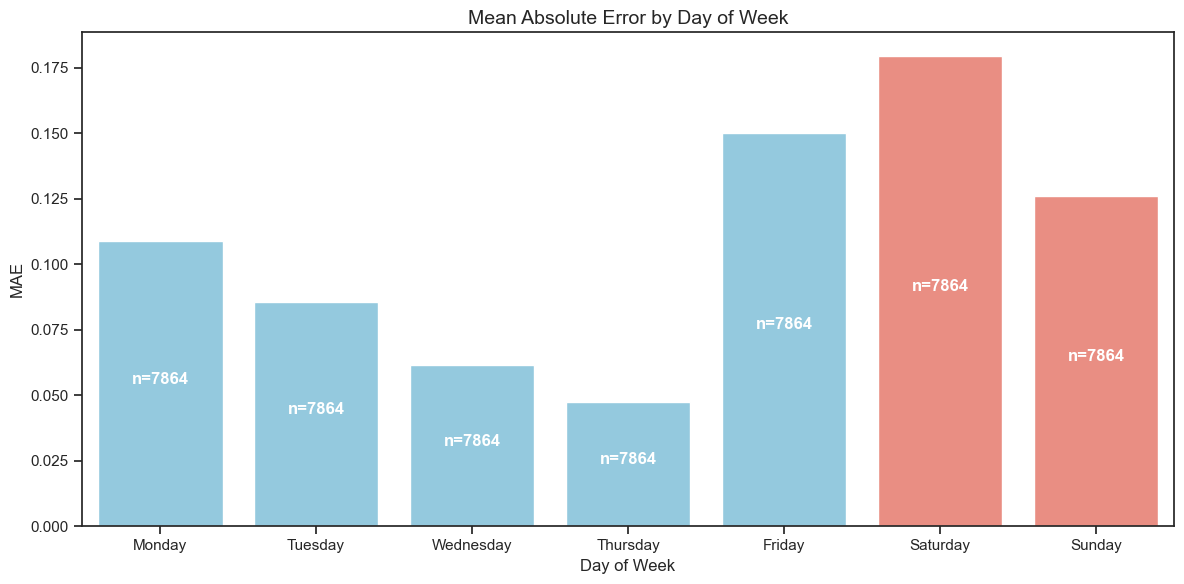

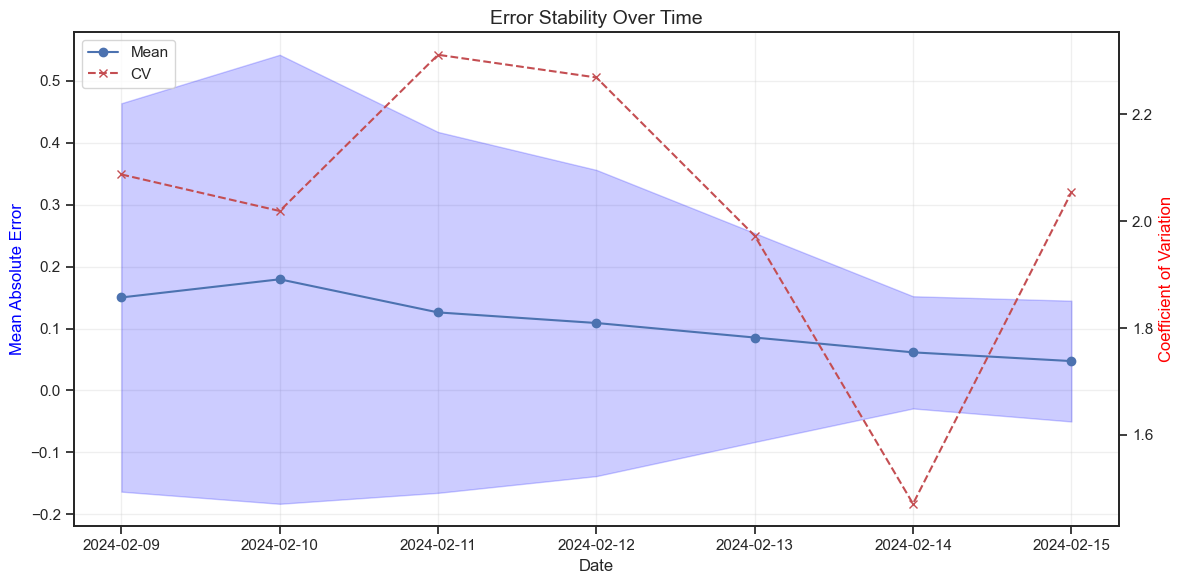


--- KEY TEMPORAL INSIGHTS ---
Weekend vs Weekday Difference: 68.39% higher error on weekends
Correlation between time and error: -0.1675
Best performing day: Thursday (MAE = 0.0475)
Worst performing day: Saturday (MAE = 0.1795)
Average error volatility (CV): 2.0263


In [13]:
if __name__ == "__main__":
    # Define paths
    results_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\NN\strap_results.csv"
    geojson_path = r"C:\Users\mvk\Documents\DATA_school\thesis\data_new\paris\2024-09-06\neighbourhoods.geojson"
    output_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\NN\Temporal"
    daily_metrics_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\Model\xgboost_results_daily_metrics.csv"

    # Run analysis
    run_simple_temporal_analysis(results_path, daily_metrics_path, output_dir)